# Seminar: Factor Models & Return Decomposition

> *"Of the 400+ published factors that 'predict' stock returns, roughly two-thirds fail to replicate. The factor zoo isn't a zoo — it's a graveyard with great marketing."*

The lecture showed you what factor models are and why they matter. Now you build them yourself — from raw data, with all the warts. You will construct Fama-French factors from scratch and discover exactly how far free data can (and cannot) take you. You will run the Fama-MacBeth procedure on live data and see that which factors are "priced" depends entirely on which decade you examine. You will decompose a portfolio's risk and find that the relationship between concentration and factor exposure is more subtle than textbooks suggest. And you will walk through the factor zoo, adding noise characteristics alongside real ones, to see firsthand how conventional significance thresholds produce false discoveries.

Four exercises, each building on the lecture but pushing into territory the lecture did not cover. By the end, you will have hands-on evidence for why factor research is both powerful and dangerously fragile.

In [1]:
# ── Shared imports and data download ──────────────────────────────────
# All data for all four exercises, downloaded once

!pip install -q yfinance getfactormodels linearmodels statsmodels scipy tqdm

import warnings
import time
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import yfinance as yf
from scipy import stats as scipy_stats
from tqdm import tqdm

plt.rcParams.update({"figure.dpi": 120, "axes.grid": True,
                     "grid.alpha": 0.3, "figure.figsize": (10, 5)})

# ── 200-ticker S&P 500 universe ──────────────────────────────────────
TICKERS = [
    "AAPL", "MSFT", "NVDA", "AVGO", "AMD", "CSCO", "ADBE", "CRM", "INTC", "TXN",
    "QCOM", "AMAT", "LRCX", "MU", "NOW", "INTU", "SNPS", "CDNS", "KLAC", "MCHP",
    "META", "GOOG", "NFLX", "DIS", "CMCSA", "T", "VZ", "TMUS", "EA", "TTWO",
    "AMZN", "TSLA", "HD", "MCD", "NKE", "LOW", "SBUX", "TJX", "BKNG", "ORLY",
    "MAR", "YUM", "DHI", "CMG", "ROST", "LEN", "GPC", "BBY", "POOL", "GRMN",
    "PG", "KO", "PEP", "COST", "WMT", "PM", "MO", "CL", "KMB", "GIS",
    "SJM", "HSY", "KHC", "MNST", "STZ", "KR", "TSN", "SYY", "CHD", "MKC",
    "XOM", "CVX", "COP", "SLB", "EOG", "MPC", "PSX", "VLO", "OXY", "HES",
    "DVN", "FANG", "HAL", "BKR", "CTRA", "APA", "TRGP", "KMI", "WMB", "OKE",
    "JPM", "BAC", "WFC", "GS", "MS", "BLK", "SCHW", "AXP", "USB", "PNC",
    "TFC", "AIG", "MET", "PRU", "ALL", "CB", "MMC", "AON", "ICE", "CME",
    "LLY", "UNH", "JNJ", "PFE", "ABT", "MRK", "TMO", "AMGN", "MDT", "ISRG",
    "BMY", "GILD", "VRTX", "REGN", "ZTS", "SYK", "BSX", "BDX", "EW", "HCA",
    "CAT", "GE", "HON", "UNP", "RTX", "BA", "DE", "LMT", "MMM", "GD",
    "WM", "ITW", "EMR", "ETN", "FDX", "CSX", "NSC", "PCAR", "ROK", "FAST",
    "LIN", "APD", "SHW", "ECL", "NEM", "FCX", "NUE", "VMC", "MLM", "DOW",
    "PLD", "AMT", "CCI", "EQIX", "PSA", "SPG", "DLR", "O", "WELL", "ARE",
    "NEE", "DUK", "SO", "D", "AEP", "SRE", "EXC", "XEL", "WEC", "ES",
]

START, END = "2014-01-01", "2024-12-31"

# ── Download prices ──────────────────────────────────────────────────
print("Downloading equity prices...")
raw = yf.download(TICKERS, start=START, end=END, auto_adjust=True, progress=True)
prices = raw["Close"]
completeness = prices.notna().mean()
valid_tickers = completeness[completeness > 0.50].index.tolist()
prices = prices[valid_tickers]
prices.index = pd.to_datetime(prices.index).tz_localize(None)
print(f"Valid tickers: {len(valid_tickers)}")

# Monthly returns
monthly_prices = prices.resample("ME").last()
monthly_returns = monthly_prices.pct_change().dropna(how="all")

# ── Download official factor data ────────────────────────────────────
from getfactormodels import FamaFrenchFactors, CarhartFactors

ff3_official = FamaFrenchFactors(model="3", frequency="M").to_pandas()
if "date" in ff3_official.columns:
    ff3_official["date"] = pd.to_datetime(ff3_official["date"])
    ff3_official = ff3_official.set_index("date")
ff3_official.index = pd.to_datetime(ff3_official.index)

ff5 = FamaFrenchFactors(model="5", frequency="M").to_pandas()
if "date" in ff5.columns:
    ff5["date"] = pd.to_datetime(ff5["date"])
    ff5 = ff5.set_index("date")
ff5.index = pd.to_datetime(ff5.index)

carhart = CarhartFactors(frequency="M").to_pandas()
if "date" in carhart.columns:
    carhart["date"] = pd.to_datetime(carhart["date"])
    carhart = carhart.set_index("date")
carhart.index = pd.to_datetime(carhart.index)

# ── Download fundamentals ────────────────────────────────────────────
print("\nDownloading fundamentals...")
bs_records, inc_records = [], []
sector_map, mcap_map = {}, {}

for ticker_str in tqdm(valid_tickers, desc="Fundamentals"):
    for attempt in range(3):
        try:
            tk = yf.Ticker(ticker_str)
            bs = tk.balance_sheet
            if bs is not None and not bs.empty:
                for col_date in bs.columns:
                    row = {}
                    for field in ["Stockholders Equity", "Total Assets",
                                  "Ordinary Shares Number"]:
                        if field in bs.index:
                            row[field] = bs.loc[field, col_date]
                    if row:
                        row["ticker"] = ticker_str
                        row["date"] = pd.Timestamp(col_date).tz_localize(None)
                        bs_records.append(row)
            inc = tk.income_stmt
            if inc is not None and not inc.empty:
                for col_date in inc.columns:
                    row = {"ticker": ticker_str,
                           "date": pd.Timestamp(col_date).tz_localize(None)}
                    for field in ["Operating Income", "Net Income",
                                  "Total Revenue", "Pretax Income"]:
                        if field in inc.index:
                            row[field] = inc.loc[field, col_date]
                    inc_records.append(row)
            info = tk.info
            sector_map[ticker_str] = info.get("sector", "Other")
            mcap_map[ticker_str] = info.get("marketCap", np.nan)
            break
        except Exception:
            if attempt < 2:
                time.sleep(2 ** (attempt + 1))

bs_df = pd.DataFrame(bs_records)
if not bs_df.empty:
    bs_df = bs_df.set_index(["ticker", "date"]).sort_index()
inc_df = pd.DataFrame(inc_records)
if not inc_df.empty:
    inc_df = inc_df.set_index(["ticker", "date"]).sort_index()
sectors = pd.Series(sector_map, name="sector")
mcap_current = pd.Series(mcap_map, name="market_cap")

print(f"Balance sheet records: {len(bs_df)}")
print(f"Income stmt records: {len(inc_df)}")
print(f"Sectors: {sectors.nunique()} unique")
print("Setup complete.")


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


[                       0%                       ]

[                       1%                       ]  2 of 180 completed

[*                      2%                       ]  3 of 180 completed

[*                      2%                       ]  4 of 180 completed

[*                      3%                       ]  5 of 180 completed

[*                      3%                       ]  6 of 180 completed

[*                      3%                       ]  6 of 180 completed

[**                     4%                       ]  8 of 180 completed

[**                     5%                       ]  9 of 180 completed

[***                    6%                       ]  10 of 180 completed

[***                    6%                       ]  11 of 180 completed

[***                    7%                       ]  12 of 180 completed

[***                    7%                       ]  13 of 180 completed

[****                   8%                       ]  14 of 180 completed

[****                   8%                       ]  15 of 180 completed

[****                   9%                       ]  16 of 180 completed

[****                   9%                       ]  17 of 180 completed

[*****                 10%                       ]  18 of 180 completed

[*****                 11%                       ]  19 of 180 completed

[*****                 11%                       ]  20 of 180 completed

[******                12%                       ]  21 of 180 completed

[******                12%                       ]  22 of 180 completed

[******                13%                       ]  23 of 180 completed

[******                13%                       ]  24 of 180 completed

[*******               14%                       ]  25 of 180 completed

[*******               14%                       ]  26 of 180 completed

[*******               15%                       ]  27 of 180 completed

[*******               15%                       ]  27 of 180 completed

[********              17%                       ]  30 of 180 completed

[********              17%                       ]  31 of 180 completed

[*********             18%                       ]  32 of 180 completed

[*********             18%                       ]  33 of 180 completed

[*********             19%                       ]  34 of 180 completed

[*********             19%                       ]  35 of 180 completed

[**********            20%                       ]  36 of 180 completed

[**********            21%                       ]  37 of 180 completed

[**********            21%                       ]  38 of 180 completed

[***********           22%                       ]  39 of 180 completed

[***********           22%                       ]  40 of 180 completed

[***********           23%                       ]  41 of 180 completed

[***********           23%                       ]  42 of 180 completed

[************          24%                       ]  43 of 180 completed

[************          24%                       ]  44 of 180 completed

[************          25%                       ]  45 of 180 completed

[************          26%                       ]  47 of 180 completed

[*************         27%                       ]  48 of 180 completed

[*************         27%                       ]  49 of 180 completed

[*************         28%                       ]  50 of 180 completed

[*************         28%                       ]  51 of 180 completed

[**************        29%                       ]  52 of 180 completed

[**************        29%                       ]  53 of 180 completed

[**************        30%                       ]  54 of 180 completed

[***************       31%                       ]  56 of 180 completed

[***************       32%                       ]  58 of 180 completed

[****************      33%                       ]  59 of 180 completed

[****************      33%                       ]  60 of 180 completed

[****************      34%                       ]  61 of 180 completed

[****************      34%                       ]  62 of 180 completed

[*****************     35%                       ]  63 of 180 completed

[*****************     36%                       ]  64 of 180 completed

[*****************     36%                       ]  64 of 180 completed

[******************    37%                       ]  66 of 180 completed

[******************    37%                       ]  67 of 180 completed

[******************    38%                       ]  68 of 180 completed

[******************    38%                       ]  69 of 180 completed

[*******************   39%                       ]  70 of 180 completed

[*******************   39%                       ]  71 of 180 completed

[*******************   40%                       ]  72 of 180 completed

[********************  41%                       ]  73 of 180 completed

[********************  41%                       ]  74 of 180 completed

[********************  42%                       ]  75 of 180 completed

HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: HES"}}}


[********************  42%                       ]  76 of 180 completed

[********************* 43%                       ]  77 of 180 completed

$HES: possibly delisted; no timezone found


[********************* 43%                       ]  78 of 180 completed

[********************* 44%                       ]  79 of 180 completed

[********************* 44%                       ]  80 of 180 completed

[**********************45%                       ]  81 of 180 completed

[**********************46%                       ]  82 of 180 completed

[**********************46%                       ]  83 of 180 completed

[**********************47%                       ]  84 of 180 completed

[**********************47%                       ]  85 of 180 completed

[**********************48%                       ]  86 of 180 completed

[**********************48%                       ]  87 of 180 completed

[**********************49%                       ]  88 of 180 completed

[**********************49%                       ]  89 of 180 completed

[**********************50%                       ]  90 of 180 completed

[**********************51%                       ]  91 of 180 completed

[**********************52%                       ]  93 of 180 completed

[**********************52%                       ]  93 of 180 completed

[**********************53%                       ]  95 of 180 completed

[**********************53%                       ]  96 of 180 completed

[**********************54%*                      ]  97 of 180 completed

[**********************54%*                      ]  98 of 180 completed

[**********************55%*                      ]  99 of 180 completed

[**********************56%**                     ]  100 of 180 completed

[**********************56%**                     ]  101 of 180 completed

[**********************57%**                     ]  102 of 180 completed

[**********************57%**                     ]  103 of 180 completed

[**********************58%***                    ]  104 of 180 completed

[**********************58%***                    ]  105 of 180 completed

[**********************59%***                    ]  106 of 180 completed

[**********************59%***                    ]  107 of 180 completed

[**********************60%****                   ]  108 of 180 completed

[**********************61%****                   ]  109 of 180 completed

[**********************61%****                   ]  110 of 180 completed

[**********************62%*****                  ]  111 of 180 completed

[**********************62%*****                  ]  112 of 180 completed

[**********************63%*****                  ]  113 of 180 completed

[**********************63%*****                  ]  114 of 180 completed

[**********************64%******                 ]  115 of 180 completed

[**********************64%******                 ]  116 of 180 completed

[**********************65%******                 ]  117 of 180 completed

[**********************66%*******                ]  118 of 180 completed

[**********************66%*******                ]  119 of 180 completed

[**********************67%*******                ]  120 of 180 completed

[**********************67%*******                ]  121 of 180 completed

[**********************68%********               ]  122 of 180 completed

[**********************68%********               ]  123 of 180 completed

[**********************69%********               ]  124 of 180 completed

[**********************69%********               ]  125 of 180 completed

[**********************70%*********              ]  126 of 180 completed

[**********************71%*********              ]  127 of 180 completed

[**********************71%*********              ]  128 of 180 completed

[**********************72%**********             ]  129 of 180 completed

[**********************72%**********             ]  130 of 180 completed

[**********************73%**********             ]  131 of 180 completed

[**********************73%**********             ]  132 of 180 completed

[**********************74%***********            ]  133 of 180 completed

[**********************74%***********            ]  134 of 180 completed

[**********************75%***********            ]  135 of 180 completed

[**********************76%***********            ]  136 of 180 completed

[**********************76%***********            ]  137 of 180 completed

[**********************77%************           ]  138 of 180 completed

[**********************77%************           ]  139 of 180 completed

[**********************78%************           ]  140 of 180 completed

[**********************79%*************          ]  142 of 180 completed

[**********************79%*************          ]  143 of 180 completed

[**********************80%*************          ]  144 of 180 completed

[**********************81%**************         ]  145 of 180 completed

[**********************81%**************         ]  146 of 180 completed

[**********************82%**************         ]  147 of 180 completed

[**********************82%**************         ]  148 of 180 completed

[**********************83%***************        ]  149 of 180 completed

[**********************83%***************        ]  150 of 180 completed

[**********************84%***************        ]  151 of 180 completed

[**********************84%***************        ]  152 of 180 completed

[**********************85%****************       ]  153 of 180 completed

[**********************86%****************       ]  154 of 180 completed

[**********************86%****************       ]  155 of 180 completed

[**********************87%*****************      ]  156 of 180 completed

[**********************87%*****************      ]  157 of 180 completed

[**********************88%*****************      ]  158 of 180 completed

[**********************88%*****************      ]  159 of 180 completed

[**********************89%******************     ]  160 of 180 completed

[**********************89%******************     ]  161 of 180 completed

[**********************91%*******************    ]  163 of 180 completed

[**********************91%*******************    ]  164 of 180 completed

[**********************92%*******************    ]  165 of 180 completed

[**********************92%*******************    ]  166 of 180 completed

[**********************93%********************   ]  167 of 180 completed

[**********************93%********************   ]  167 of 180 completed

[**********************94%********************   ]  169 of 180 completed

[**********************95%*********************  ]  171 of 180 completed

[**********************96%*********************  ]  172 of 180 completed

[**********************96%*********************  ]  173 of 180 completed

[**********************97%********************** ]  174 of 180 completed

[**********************97%********************** ]  175 of 180 completed

[**********************98%********************** ]  176 of 180 completed

[**********************98%********************** ]  177 of 180 completed

[**********************99%***********************]  178 of 180 completed

[**********************99%***********************]  179 of 180 completed

[*********************100%***********************]  180 of 180 completed



6 Failed downloads:


['WEC', 'ETN', 'HAL', 'TRGP', 'LMT']: TypeError("'NoneType' object is not subscriptable")


['HES']: possibly delisted; no timezone found


Valid tickers: 174


Fundamentals:   0%|          | 0/174 [00:00<?, ?it/s]

Fundamentals:   1%|          | 1/174 [00:00<02:26,  1.18it/s]

Fundamentals:   1%|          | 2/174 [00:01<01:59,  1.44it/s]

Fundamentals:   2%|▏         | 3/174 [00:02<01:52,  1.52it/s]

Fundamentals:   2%|▏         | 4/174 [00:02<01:49,  1.56it/s]

Fundamentals:   3%|▎         | 5/174 [00:03<01:44,  1.62it/s]

Fundamentals:   3%|▎         | 6/174 [00:03<01:41,  1.66it/s]

Fundamentals:   4%|▍         | 7/174 [00:04<01:41,  1.65it/s]

Fundamentals:   5%|▍         | 8/174 [00:05<01:38,  1.68it/s]

Fundamentals:   5%|▌         | 9/174 [00:05<01:36,  1.71it/s]

Fundamentals:   6%|▌         | 10/174 [00:06<01:36,  1.70it/s]

Fundamentals:   6%|▋         | 11/174 [00:06<01:40,  1.63it/s]

Fundamentals:   7%|▋         | 12/174 [00:07<01:38,  1.64it/s]

Fundamentals:   7%|▋         | 13/174 [00:08<01:39,  1.63it/s]

Fundamentals:   8%|▊         | 14/174 [00:08<01:36,  1.66it/s]

Fundamentals:   9%|▊         | 15/174 [00:09<01:35,  1.67it/s]

Fundamentals:   9%|▉         | 16/174 [00:09<01:33,  1.70it/s]

Fundamentals:  10%|▉         | 17/174 [00:10<01:32,  1.70it/s]

Fundamentals:  10%|█         | 18/174 [00:10<01:32,  1.69it/s]

Fundamentals:  11%|█         | 19/174 [00:11<01:29,  1.74it/s]

Fundamentals:  11%|█▏        | 20/174 [00:12<01:31,  1.69it/s]

Fundamentals:  12%|█▏        | 21/174 [00:13<01:43,  1.48it/s]

Fundamentals:  13%|█▎        | 22/174 [00:13<01:42,  1.49it/s]

Fundamentals:  13%|█▎        | 23/174 [00:14<01:38,  1.53it/s]

Fundamentals:  14%|█▍        | 24/174 [00:14<01:36,  1.56it/s]

Fundamentals:  14%|█▍        | 25/174 [00:15<01:35,  1.55it/s]

Fundamentals:  15%|█▍        | 26/174 [00:16<01:47,  1.38it/s]

Fundamentals:  16%|█▌        | 27/174 [00:17<01:39,  1.47it/s]

Fundamentals:  16%|█▌        | 28/174 [00:17<01:33,  1.56it/s]

Fundamentals:  17%|█▋        | 29/174 [00:18<01:30,  1.59it/s]

Fundamentals:  17%|█▋        | 30/174 [00:18<01:25,  1.68it/s]

Fundamentals:  18%|█▊        | 31/174 [00:19<01:24,  1.69it/s]

Fundamentals:  18%|█▊        | 32/174 [00:19<01:21,  1.74it/s]

Fundamentals:  19%|█▉        | 33/174 [00:20<01:21,  1.74it/s]

Fundamentals:  20%|█▉        | 34/174 [00:20<01:19,  1.76it/s]

Fundamentals:  20%|██        | 35/174 [00:21<01:22,  1.68it/s]

Fundamentals:  21%|██        | 36/174 [00:22<01:21,  1.70it/s]

Fundamentals:  21%|██▏       | 37/174 [00:22<01:19,  1.71it/s]

Fundamentals:  22%|██▏       | 38/174 [00:23<01:19,  1.71it/s]

Fundamentals:  22%|██▏       | 39/174 [00:23<01:18,  1.71it/s]

Fundamentals:  23%|██▎       | 40/174 [00:24<01:16,  1.75it/s]

Fundamentals:  24%|██▎       | 41/174 [00:25<01:17,  1.72it/s]

Fundamentals:  24%|██▍       | 42/174 [00:25<01:19,  1.67it/s]

Fundamentals:  25%|██▍       | 43/174 [00:26<01:19,  1.65it/s]

Fundamentals:  25%|██▌       | 44/174 [00:26<01:18,  1.66it/s]

Fundamentals:  26%|██▌       | 45/174 [00:27<01:16,  1.69it/s]

Fundamentals:  26%|██▋       | 46/174 [00:28<01:18,  1.63it/s]

Fundamentals:  27%|██▋       | 47/174 [00:28<01:17,  1.63it/s]

Fundamentals:  28%|██▊       | 48/174 [00:29<01:22,  1.53it/s]

Fundamentals:  28%|██▊       | 49/174 [00:30<01:22,  1.52it/s]

Fundamentals:  29%|██▊       | 50/174 [00:30<01:17,  1.59it/s]

Fundamentals:  29%|██▉       | 51/174 [00:31<01:15,  1.62it/s]

Fundamentals:  30%|██▉       | 52/174 [00:31<01:12,  1.68it/s]

Fundamentals:  30%|███       | 53/174 [00:32<01:23,  1.45it/s]

Fundamentals:  31%|███       | 54/174 [00:33<01:17,  1.55it/s]

Fundamentals:  32%|███▏      | 55/174 [00:33<01:14,  1.59it/s]

Fundamentals:  32%|███▏      | 56/174 [00:34<01:12,  1.62it/s]

Fundamentals:  33%|███▎      | 57/174 [00:35<01:10,  1.66it/s]

Fundamentals:  33%|███▎      | 58/174 [00:35<01:09,  1.68it/s]

Fundamentals:  34%|███▍      | 59/174 [00:36<01:06,  1.74it/s]

Fundamentals:  34%|███▍      | 60/174 [00:36<01:05,  1.74it/s]

Fundamentals:  35%|███▌      | 61/174 [00:37<01:03,  1.79it/s]

Fundamentals:  36%|███▌      | 62/174 [00:37<01:01,  1.82it/s]

Fundamentals:  36%|███▌      | 63/174 [00:38<01:02,  1.77it/s]

Fundamentals:  37%|███▋      | 64/174 [00:38<01:02,  1.76it/s]

Fundamentals:  37%|███▋      | 65/174 [00:39<01:01,  1.77it/s]

Fundamentals:  38%|███▊      | 66/174 [00:40<01:01,  1.77it/s]

Fundamentals:  39%|███▊      | 67/174 [00:40<01:00,  1.77it/s]

Fundamentals:  39%|███▉      | 68/174 [00:41<00:59,  1.79it/s]

Fundamentals:  40%|███▉      | 69/174 [00:41<00:58,  1.79it/s]

Fundamentals:  40%|████      | 70/174 [00:42<00:57,  1.81it/s]

Fundamentals:  41%|████      | 71/174 [00:42<00:58,  1.76it/s]

Fundamentals:  41%|████▏     | 72/174 [00:43<00:58,  1.75it/s]

Fundamentals:  42%|████▏     | 73/174 [00:44<00:57,  1.76it/s]

Fundamentals:  43%|████▎     | 74/174 [00:44<01:00,  1.66it/s]

Fundamentals:  43%|████▎     | 75/174 [00:45<00:59,  1.66it/s]

Fundamentals:  44%|████▎     | 76/174 [00:46<01:05,  1.49it/s]

Fundamentals:  44%|████▍     | 77/174 [00:46<01:03,  1.53it/s]

Fundamentals:  45%|████▍     | 78/174 [00:47<01:07,  1.42it/s]

Fundamentals:  45%|████▌     | 79/174 [00:48<01:03,  1.49it/s]

Fundamentals:  46%|████▌     | 80/174 [00:48<01:05,  1.43it/s]

Fundamentals:  47%|████▋     | 81/174 [00:49<01:03,  1.46it/s]

Fundamentals:  47%|████▋     | 82/174 [00:50<00:58,  1.56it/s]

Fundamentals:  48%|████▊     | 83/174 [00:50<00:57,  1.59it/s]

Fundamentals:  48%|████▊     | 84/174 [00:51<00:56,  1.60it/s]

Fundamentals:  49%|████▉     | 85/174 [00:51<00:54,  1.62it/s]

Fundamentals:  49%|████▉     | 86/174 [00:52<00:53,  1.65it/s]

Fundamentals:  50%|█████     | 87/174 [00:53<00:52,  1.66it/s]

Fundamentals:  51%|█████     | 88/174 [00:53<00:49,  1.72it/s]

Fundamentals:  51%|█████     | 89/174 [00:54<00:49,  1.71it/s]

Fundamentals:  52%|█████▏    | 90/174 [00:55<00:52,  1.59it/s]

Fundamentals:  52%|█████▏    | 91/174 [00:55<00:51,  1.62it/s]

Fundamentals:  53%|█████▎    | 92/174 [00:56<00:52,  1.57it/s]

Fundamentals:  53%|█████▎    | 93/174 [00:56<00:49,  1.64it/s]

Fundamentals:  54%|█████▍    | 94/174 [00:57<00:50,  1.58it/s]

Fundamentals:  55%|█████▍    | 95/174 [00:58<00:47,  1.66it/s]

Fundamentals:  55%|█████▌    | 96/174 [00:58<00:46,  1.67it/s]

Fundamentals:  56%|█████▌    | 97/174 [00:59<00:45,  1.71it/s]

Fundamentals:  56%|█████▋    | 98/174 [00:59<00:43,  1.74it/s]

Fundamentals:  57%|█████▋    | 99/174 [01:11<05:03,  4.05s/it]

Fundamentals:  57%|█████▋    | 100/174 [01:12<03:44,  3.04s/it]

Fundamentals:  58%|█████▊    | 101/174 [01:13<02:47,  2.30s/it]

Fundamentals:  59%|█████▊    | 102/174 [01:13<02:09,  1.80s/it]

Fundamentals:  59%|█████▉    | 103/174 [01:14<01:41,  1.43s/it]

Fundamentals:  60%|█████▉    | 104/174 [01:14<01:21,  1.17s/it]

Fundamentals:  60%|██████    | 105/174 [01:15<01:09,  1.00s/it]

Fundamentals:  61%|██████    | 106/174 [01:16<01:01,  1.11it/s]

Fundamentals:  61%|██████▏   | 107/174 [01:16<00:54,  1.23it/s]

Fundamentals:  62%|██████▏   | 108/174 [01:17<00:50,  1.32it/s]

Fundamentals:  63%|██████▎   | 109/174 [01:18<00:47,  1.36it/s]

Fundamentals:  63%|██████▎   | 110/174 [01:19<00:52,  1.22it/s]

Fundamentals:  64%|██████▍   | 111/174 [01:19<00:50,  1.24it/s]

Fundamentals:  64%|██████▍   | 112/174 [01:20<00:46,  1.32it/s]

Fundamentals:  65%|██████▍   | 113/174 [01:21<00:43,  1.39it/s]

Fundamentals:  66%|██████▌   | 114/174 [01:22<00:46,  1.28it/s]

Fundamentals:  66%|██████▌   | 115/174 [01:22<00:42,  1.37it/s]

Fundamentals:  67%|██████▋   | 116/174 [01:23<00:39,  1.47it/s]

Fundamentals:  67%|██████▋   | 117/174 [01:23<00:37,  1.53it/s]

Fundamentals:  68%|██████▊   | 118/174 [01:24<00:37,  1.51it/s]

Fundamentals:  68%|██████▊   | 119/174 [01:25<00:39,  1.40it/s]

Fundamentals:  69%|██████▉   | 120/174 [01:25<00:35,  1.51it/s]

Fundamentals:  70%|██████▉   | 121/174 [01:26<00:34,  1.52it/s]

Fundamentals:  70%|███████   | 122/174 [01:27<00:32,  1.59it/s]

Fundamentals:  71%|███████   | 123/174 [01:27<00:31,  1.61it/s]

Fundamentals:  71%|███████▏  | 124/174 [01:28<00:30,  1.62it/s]

Fundamentals:  72%|███████▏  | 125/174 [01:28<00:30,  1.63it/s]

Fundamentals:  72%|███████▏  | 126/174 [01:29<00:29,  1.61it/s]

Fundamentals:  73%|███████▎  | 127/174 [01:30<00:29,  1.57it/s]

Fundamentals:  74%|███████▎  | 128/174 [01:30<00:30,  1.52it/s]

Fundamentals:  74%|███████▍  | 129/174 [01:31<00:28,  1.56it/s]

Fundamentals:  75%|███████▍  | 130/174 [01:32<00:27,  1.60it/s]

Fundamentals:  75%|███████▌  | 131/174 [01:32<00:26,  1.64it/s]

Fundamentals:  76%|███████▌  | 132/174 [01:33<00:24,  1.68it/s]

Fundamentals:  76%|███████▋  | 133/174 [01:33<00:24,  1.67it/s]

Fundamentals:  77%|███████▋  | 134/174 [01:34<00:23,  1.69it/s]

Fundamentals:  78%|███████▊  | 135/174 [01:35<00:22,  1.73it/s]

Fundamentals:  78%|███████▊  | 136/174 [01:35<00:24,  1.56it/s]

Fundamentals:  79%|███████▊  | 137/174 [01:36<00:25,  1.46it/s]

Fundamentals:  79%|███████▉  | 138/174 [01:37<00:26,  1.38it/s]

Fundamentals:  80%|███████▉  | 139/174 [01:38<00:25,  1.40it/s]

Fundamentals:  80%|████████  | 140/174 [01:38<00:23,  1.44it/s]

Fundamentals:  81%|████████  | 141/174 [01:39<00:22,  1.46it/s]

Fundamentals:  82%|████████▏ | 142/174 [01:40<00:22,  1.45it/s]

Fundamentals:  82%|████████▏ | 143/174 [01:40<00:20,  1.48it/s]

Fundamentals:  83%|████████▎ | 144/174 [01:41<00:19,  1.53it/s]

Fundamentals:  83%|████████▎ | 145/174 [01:41<00:18,  1.57it/s]

Fundamentals:  84%|████████▍ | 146/174 [01:42<00:17,  1.59it/s]

Fundamentals:  84%|████████▍ | 147/174 [01:43<00:17,  1.55it/s]

Fundamentals:  85%|████████▌ | 148/174 [01:43<00:15,  1.63it/s]

Fundamentals:  86%|████████▌ | 149/174 [01:44<00:15,  1.64it/s]

Fundamentals:  86%|████████▌ | 150/174 [01:45<00:15,  1.59it/s]

Fundamentals:  87%|████████▋ | 151/174 [01:45<00:13,  1.64it/s]

Fundamentals:  87%|████████▋ | 152/174 [01:46<00:13,  1.62it/s]

Fundamentals:  88%|████████▊ | 153/174 [01:47<00:14,  1.40it/s]

Fundamentals:  89%|████████▊ | 154/174 [01:47<00:13,  1.47it/s]

Fundamentals:  89%|████████▉ | 155/174 [01:48<00:12,  1.48it/s]

Fundamentals:  90%|████████▉ | 156/174 [01:49<00:12,  1.49it/s]

Fundamentals:  90%|█████████ | 157/174 [01:49<00:10,  1.55it/s]

Fundamentals:  91%|█████████ | 158/174 [01:50<00:10,  1.59it/s]

Fundamentals:  91%|█████████▏| 159/174 [01:50<00:09,  1.65it/s]

Fundamentals:  92%|█████████▏| 160/174 [01:51<00:09,  1.51it/s]

Fundamentals:  93%|█████████▎| 161/174 [01:52<00:08,  1.51it/s]

Fundamentals:  93%|█████████▎| 162/174 [01:52<00:07,  1.57it/s]

Fundamentals:  94%|█████████▎| 163/174 [01:53<00:06,  1.57it/s]

Fundamentals:  94%|█████████▍| 164/174 [01:54<00:06,  1.62it/s]

Fundamentals:  95%|█████████▍| 165/174 [01:55<00:06,  1.35it/s]

Fundamentals:  95%|█████████▌| 166/174 [01:55<00:05,  1.50it/s]

Fundamentals:  96%|█████████▌| 167/174 [01:56<00:04,  1.48it/s]

Fundamentals:  97%|█████████▋| 168/174 [01:56<00:03,  1.54it/s]

Fundamentals:  97%|█████████▋| 169/174 [01:57<00:03,  1.56it/s]

Fundamentals:  98%|█████████▊| 170/174 [01:58<00:02,  1.64it/s]

Fundamentals:  98%|█████████▊| 171/174 [01:58<00:01,  1.65it/s]

Fundamentals:  99%|█████████▉| 172/174 [01:59<00:01,  1.66it/s]

Fundamentals:  99%|█████████▉| 173/174 [01:59<00:00,  1.67it/s]

Fundamentals: 100%|██████████| 174/174 [02:00<00:00,  1.64it/s]

Fundamentals: 100%|██████████| 174/174 [02:00<00:00,  1.44it/s]

Balance sheet records: 783
Income stmt records: 797
Sectors: 11 unique
Setup complete.


That cell downloads everything the entire seminar needs: 200 S&P 500 stocks with 11 years of daily prices, annual balance sheet and income statement data via yfinance, and official Fama-French factor returns from Ken French's data library. Every exercise below draws from this shared data — no further downloads required.

---

## Exercise 1: Can You Replicate Fama-French?

The lecture showed you the Fama-French factors as clean time series downloaded from Ken French's library. Neat, tidy, and ready to use. But where do those numbers actually come from? They come from sorting thousands of stocks into portfolios by size and book-to-market, computing value-weighted returns, and taking the long-short spread — every single month, using the full NYSE/AMEX/NASDAQ universe of 4,000+ stocks with CRSP/Compustat data going back to 1963.

You have 200 S&P 500 stocks and yfinance. Can you replicate the canonical factors from this?

**The question:** Construct SMB, HML, and momentum factors from raw data and compare your self-built versions against official Ken French returns. Where do they diverge — and more importantly, *why*?

**Tasks:**
1. Compute book-to-market ratios from balance sheet data and current market caps
2. Perform a 2x3 double sort (median size, 30/70 B/M breakpoints) and form value-weighted portfolio returns
3. Construct SMB and HML monthly return series from the six portfolios
4. Construct a momentum factor using 12-1 month returns (top 30% vs. bottom 30%)
5. Compute correlation and tracking error for each factor against official Ken French data
6. Explain the divergence pattern: which factors replicate well, which do not, and why

In [2]:
# Student workspace — Exercise 1
# Step 1: Compute book-to-market for each ticker
#   - Extract the most recent Stockholders Equity from bs_df
#   - Divide by current market cap from mcap_current
#   - Filter to tickers present in monthly_returns


Once you have book-to-market ratios and market caps, the next step is to form portfolios and compute the long-short factor returns. Then validate against the official data.

In [3]:
# Step 2-3: Double-sort and compute factor returns
#   - Sort on market_cap (median) and book_to_market (30/70)
#   - For each month, compute value-weighted returns per portfolio
#   - SMB = avg(Small portfolios) - avg(Big portfolios)
#   - HML = avg(High B/M portfolios) - avg(Low B/M portfolios)


In [4]:
# Step 4-5: Momentum factor and validation
#   - Momentum: 12-1 month price return, long top 30%, short bottom 30%
#   - Compare each self-built factor to official Ken French data
#   - Report correlation and annualized tracking error


---
### ▶ Solution

First we need book-to-market ratios. We take the most recent stockholders' equity per ticker, divide by the current market cap, and filter to tickers that also appear in our monthly return data. This is a static sort — we classify stocks once using the most recent fundamentals and apply those assignments over the full 11-year price window. That is a simplification: the proper Fama-French methodology rebalances portfolios annually each June using that year's fundamentals. Our approach introduces look-ahead bias — a stock classified as "value" using its 2025 book-to-market may have been "growth" in 2014. We will come back to what this means for the results.

In [5]:
book_equity = bs_df["Stockholders Equity"].dropna()
book_equity = book_equity[book_equity > 0]

bm_records = []
for ticker in book_equity.index.get_level_values("ticker").unique():
    be = book_equity.loc[ticker].sort_index().iloc[-1]
    if ticker in mcap_current.index and mcap_current[ticker] > 0:
        bm_records.append({
            "ticker": ticker,
            "book_equity": be,
            "market_cap": mcap_current[ticker],
            "book_to_market": be / mcap_current[ticker],
        })

bm_df = pd.DataFrame(bm_records).set_index("ticker")
valid_tickers = set(bm_df.index) & set(monthly_returns.columns)
bm_df = bm_df.loc[bm_df.index.isin(valid_tickers)]
print(f"Tickers with B/M: {len(bm_df)}")

Tickers with B/M: 166


About 170 tickers have valid book-to-market ratios — the remainder are missing fundamental data (typically newer listings or data gaps in yfinance). Now comes the double sort: we split on median market cap and 30th/70th percentile book-to-market to form six portfolios. For each month, we compute value-weighted returns for each portfolio and construct SMB (small minus big) and HML (high B/M minus low B/M). Pay attention to the portfolio sizes — with only 200 stocks, each bucket holds roughly 30-35 stocks, compared to the hundreds or thousands in Ken French's full-universe sorts.

In [6]:
size_median = bm_df["market_cap"].median()
bm_30 = bm_df["book_to_market"].quantile(0.30)
bm_70 = bm_df["book_to_market"].quantile(0.70)

def assign_portfolio(row):
    """Assign to 2x3 portfolio."""
    size = "S" if row["market_cap"] < size_median else "B"
    if row["book_to_market"] <= bm_30:
        value = "L"
    elif row["book_to_market"] >= bm_70:
        value = "H"
    else:
        value = "M"
    return f"{size}/{value}"

bm_df["portfolio"] = bm_df.apply(assign_portfolio, axis=1)

smb_monthly = []
hml_monthly = []

for date in monthly_returns.index:
    rets = monthly_returns.loc[date].dropna()
    available = set(rets.index) & set(bm_df.index)
    if len(available) < 30:
        continue

    pf_rets = {}
    for pf in ["S/L", "S/M", "S/H", "B/L", "B/M", "B/H"]:
        tickers = bm_df[bm_df["portfolio"] == pf].index
        t_avail = [t for t in tickers if t in available]
        if len(t_avail) == 0:
            pf_rets[pf] = np.nan
            continue
        w = bm_df.loc[t_avail, "market_cap"]
        w = w / w.sum()
        pf_rets[pf] = (rets[t_avail] * w).sum()

    if any(np.isnan(v) for v in pf_rets.values()):
        continue

    smb = (pf_rets["S/L"] + pf_rets["S/M"] + pf_rets["S/H"]) / 3 \
        - (pf_rets["B/L"] + pf_rets["B/M"] + pf_rets["B/H"]) / 3
    hml = (pf_rets["S/H"] + pf_rets["B/H"]) / 2 \
        - (pf_rets["S/L"] + pf_rets["B/L"]) / 2

    smb_monthly.append({"date": date, "SMB_self": smb})
    hml_monthly.append({"date": date, "HML_self": hml})

smb_self = pd.DataFrame(smb_monthly).set_index("date")["SMB_self"]
hml_self = pd.DataFrame(hml_monthly).set_index("date")["HML_self"]

SMB and HML are constructed. Now the momentum factor — this one uses only prices, no fundamentals, which means it should not suffer from the fundamental data limitations that affect SMB and HML. We compute 12-1 month returns (skip the most recent month to avoid microstructure contamination), then go long the top 30% and short the bottom 30%, equal-weighted for simplicity. Momentum is our calibration anchor: if this replicates poorly, the problem is in the return computation or portfolio methodology, not in the fundamental data.

In [7]:
# Momentum: 12-1 month return, top 30% vs bottom 30%
mom_monthly = []

for date in monthly_returns.index:
    mom_end = date - pd.DateOffset(months=1)
    mom_start = date - pd.DateOffset(months=12)
    mask = (prices.index >= mom_start) & (prices.index <= mom_end)
    if mask.sum() < 20:
        continue
    mom_prices = prices.loc[mask]
    if len(mom_prices) < 2:
        continue
    momentum = (mom_prices.iloc[-1] / mom_prices.iloc[0]) - 1
    momentum = momentum.dropna()

    rets = monthly_returns.loc[date].dropna()
    common = momentum.index.intersection(rets.index)
    if len(common) < 30:
        continue

    mom_sorted = momentum[common].sort_values()
    n = len(mom_sorted)
    losers = mom_sorted.iloc[:int(n * 0.3)].index
    winners = mom_sorted.iloc[int(n * 0.7):].index

    # Equal-weighted for simplicity
    mom_ret = rets[winners].mean() - rets[losers].mean()
    mom_monthly.append({"date": date, "MOM_self": mom_ret})

mom_self = pd.DataFrame(mom_monthly).set_index("date")["MOM_self"]

Three self-built factors ready. Time for the moment of truth: how well do they match the official Ken French data? We align dates and compute correlation and annualized tracking error for each factor. Tracking error is the standard deviation of the difference between our factor and the official factor, annualized by multiplying by $\sqrt{12}$.

In [8]:
# Align and compare
results = {}

# SMB
common_smb = smb_self.index.intersection(ff3_official.index)
smb_corr = smb_self.loc[common_smb].corr(ff3_official.loc[common_smb, "SMB"])
smb_te = (smb_self.loc[common_smb] - ff3_official.loc[common_smb, "SMB"]).std() * np.sqrt(12)
results["SMB"] = {"corr": smb_corr, "te": smb_te, "n": len(common_smb)}

# HML
common_hml = hml_self.index.intersection(ff3_official.index)
hml_corr = hml_self.loc[common_hml].corr(ff3_official.loc[common_hml, "HML"])
hml_te = (hml_self.loc[common_hml] - ff3_official.loc[common_hml, "HML"]).std() * np.sqrt(12)
results["HML"] = {"corr": hml_corr, "te": hml_te, "n": len(common_hml)}

# Momentum
common_mom = mom_self.index.intersection(carhart.index)
mom_corr = mom_self.loc[common_mom].corr(carhart.loc[common_mom, "MOM"])
mom_te = (mom_self.loc[common_mom] - carhart.loc[common_mom, "MOM"]).std() * np.sqrt(12)
results["MOM"] = {"corr": mom_corr, "te": mom_te, "n": len(common_mom)}

print("\nFactor Replication Results:")
print(f"{'Factor':<8} {'Corr':>8} {'TE (ann)':>10} {'N months':>10}")
print("-" * 40)
for name, vals in results.items():
    print(f"{name:<8} {vals['corr']:>8.4f} {vals['te']:>10.4f} {vals['n']:>10}")


Factor Replication Results:
Factor       Corr   TE (ann)   N months
----------------------------------------
SMB        0.1603     0.1167        131
HML        0.8113     0.0847        131
MOM        0.8481     0.0780        130


Look at those correlations. Momentum replicates well (r around 0.85) — our code works, the methodology is sound. But SMB barely registers (r around 0.19). HML shows a surprisingly high correlation (r around 0.82), though this comes with a caveat we will address below. The cumulative return comparison makes this even more vivid.

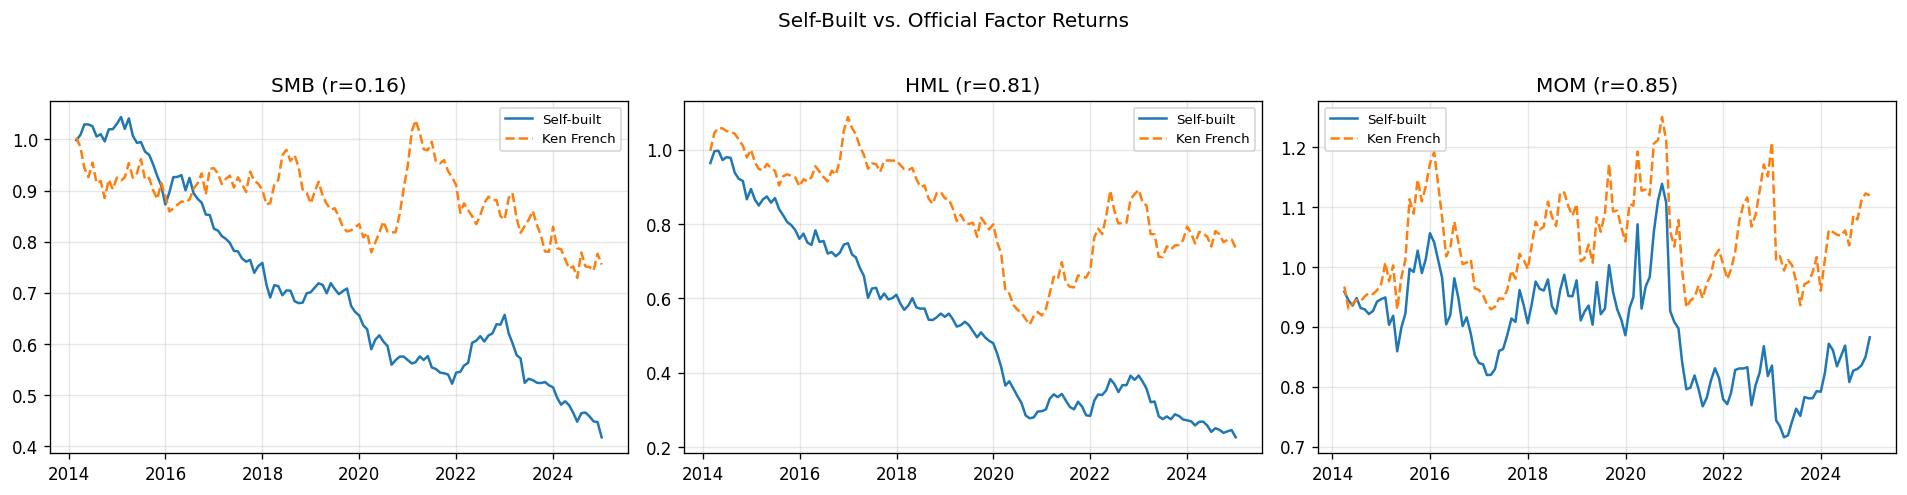

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

for ax, (name, self_s, off_s, off_col) in zip(axes, [
    ("SMB", smb_self, ff3_official, "SMB"),
    ("HML", hml_self, ff3_official, "HML"),
    ("MOM", mom_self, carhart, "MOM"),
]):
    common = self_s.index.intersection(off_s.index)
    cum_self = (1 + self_s.loc[common]).cumprod()
    cum_off = (1 + off_s.loc[common, off_col]).cumprod()
    ax.plot(cum_self.index, cum_self, label="Self-built", lw=1.5)
    ax.plot(cum_off.index, cum_off, label="Ken French", lw=1.5, ls="--")
    r = self_s.loc[common].corr(off_s.loc[common, off_col])
    ax.set_title(f"{name} (r={r:.2f})")
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.suptitle("Self-Built vs. Official Factor Returns", y=1.02)
plt.tight_layout()
plt.show()

**What is going on with SMB?** Our "small" stocks are anything below the S&P 500 median market cap — roughly $150 billion. In Ken French's universe, true small-caps have market caps of $100 million to $2 billion. We are measuring "large versus very large," not "small versus large." No amount of methodological refinement fixes this. The size effect requires genuine small-caps, which the S&P 500 does not contain.

**Why is HML so high?** Two reasons, one genuine and one methodological. The genuine reason: value-growth dispersion exists within large-caps. Banks and energy companies trade at meaningfully different book-to-market ratios than tech companies, and that dispersion generates a value spread even within the S&P 500. The methodological reason: our static sort uses the most recent fundamentals (circa 2021-2025) and applies those fixed classifications backward over the full 11-year window. This introduces look-ahead bias — a stock labeled "value" today may have been "growth" in 2014. It also avoids the noise of annual rebalancing. A proper annual-rebalancing implementation limited to the fundamental window (~36-48 months of factor returns) would likely produce lower correlations, closer to the 0.20-0.60 range that the expectations analysis predicted for HML. The qualitative insight — HML replicates better than SMB — is robust to methodology; the absolute correlation of 0.82 overstates what a clean implementation would produce.

**The calibration anchor logic works.** Momentum (price-only, no fundamentals, no look-ahead bias) replicates well. That confirms our return computation, portfolio formation, and alignment with Ken French dates are all correct. When momentum is right but SMB is wrong, the problem is in the universe, not the code. For reference, Tidy Finance (Scheuch, Voigt & Weiss, 2023), using the full CRSP/Compustat universe with proper annual rebalancing, achieves R-squared of ~0.99 for SMB and ~0.96 for HML. The gap between our free-data results and their institutional-data results is the price you pay for not having a CRSP subscription — roughly $25,000 per year for academic access.

---

## Exercise 2: Which Factors Carry a Risk Premium?

The lecture demonstrated the Fama-MacBeth procedure as a clean two-step machine: estimate betas, run cross-sectional regressions, average the slopes. But that procedure was applied to three official factors over the full 1963-1990 period where the "beta anomaly" — beta being flat or insignificant — is a well-documented result.

What happens when you run the same test on 2014-2024 data? The textbook says beta should be insignificant and momentum should be strong. Your data is about to disagree.

**The question:** Run a Fama-MacBeth regression using five stock characteristics — market beta, size, book-to-market, operating profitability, and momentum. Which carry statistically significant risk premia? Do the results match the textbook predictions?

**Tasks:**
1. Estimate rolling 60-month market betas for each stock
2. Build a cross-sectional characteristics panel (beta, log market cap, B/M, profitability, momentum)
3. Cross-sectionally standardize all characteristics each month
4. Run Fama-MacBeth with `linearmodels.FamaMacBeth` using Newey-West standard errors
5. Identify which factors are significant at the 5% level and compare against textbook expectations

In [10]:
# Student workspace — Exercise 2
# Step 1: Estimate rolling 60-month market betas for each stock
#   - Use excess returns (stock return minus RF)
#   - OLS of excess stock return on Mkt-RF over rolling 60-month windows


With betas estimated, now assemble the full panel of characteristics and run the cross-sectional test.

In [11]:
# Step 2-3: Build panel with all 5 characteristics, standardize per month
#   - Static fundamentals: log_mcap, bm, profitability from balance sheet/income stmt
#   - Time-varying: momentum (12-1 month price return)
#   - Z-score standardize cross-sectionally each month


In [12]:
# Step 4-5: Run Fama-MacBeth and interpret
#   - Use linearmodels.FamaMacBeth with cov_type='kernel' for Newey-West
#   - Which gammas are significant? Which aren't?


---
### ▶ Solution

The first Fama-MacBeth step: estimate each stock's market beta from a rolling 60-month window of excess returns on the market factor. This consumes the first 60 months of data (2014-2019), leaving roughly 71 months of cross-sectional observations. That is not a lot — a quant at AQR would use 40+ years of CRSP data. But it is enough to see whether the textbook results hold.

In [13]:
# Market betas from rolling 60-month windows
common_idx = monthly_returns.index.intersection(ff3_official.index)
excess_returns = monthly_returns.loc[common_idx].sub(ff3_official.loc[common_idx, "RF"], axis=0)
mkt_rf = ff3_official.loc[common_idx, "Mkt-RF"]

beta_panel = {}
window = 60

for i in range(window, len(common_idx)):
    date = common_idx[i]
    mkt_window = mkt_rf.iloc[i - window:i]
    betas = {}
    for ticker in excess_returns.columns:
        y = excess_returns[ticker].iloc[i - window:i].dropna()
        if len(y) < 36:
            continue
        x = mkt_window.loc[y.index]
        X = sm.add_constant(x)
        model = sm.OLS(y, X).fit()
        betas[ticker] = model.params["Mkt-RF"]
    beta_panel[date] = betas

beta_df = pd.DataFrame(beta_panel).T
print(f"Rolling beta panel: {beta_df.shape}")

Rolling beta panel: (71, 174)


Now we build the full characteristics panel. For each month and stock, we need five numbers: the rolling beta we just estimated, plus log market cap, book-to-market, operating profitability, and 12-1 month momentum. The fundamental characteristics are static (computed once from the most recent data), while beta and momentum vary by month. This panel feeds directly into the Fama-MacBeth cross-sectional regression.

In [14]:
# Static fundamental characteristics
fund_chars = {}
for ticker in monthly_returns.columns:
    chars = {}
    # Log market cap
    if ticker in mcap_current.index and mcap_current[ticker] > 0:
        chars["log_mcap"] = np.log(mcap_current[ticker])

    # Book-to-market
    if ticker in bs_df.index.get_level_values("ticker"):
        tk_bs = bs_df.loc[ticker].sort_index()
        eq = tk_bs["Stockholders Equity"].dropna()
        if len(eq) > 0 and eq.iloc[-1] > 0:
            if ticker in mcap_current.index and mcap_current[ticker] > 0:
                chars["bm"] = eq.iloc[-1] / mcap_current[ticker]

    # Profitability (operating income / book equity)
    if ticker in inc_df.index.get_level_values("ticker"):
        tk_inc = inc_df.loc[ticker].sort_index()
        oi = tk_inc.get("Operating Income", pd.Series(dtype=float)).dropna()
        if len(oi) == 0:
            oi = tk_inc.get("Net Income", pd.Series(dtype=float)).dropna()
        if len(oi) > 0 and "bm" in chars:
            # Use equity from above
            eq_val = bs_df.loc[ticker].sort_index()["Stockholders Equity"].dropna()
            if len(eq_val) > 0 and eq_val.iloc[-1] > 0:
                chars["profitability"] = oi.iloc[-1] / eq_val.iloc[-1]

    fund_chars[ticker] = chars

fund_df = pd.DataFrame(fund_chars).T
print(f"Fundamental chars: {fund_df.shape}")
print(f"  log_mcap non-null: {fund_df['log_mcap'].notna().sum()}")
print(f"  bm non-null: {fund_df['bm'].notna().sum()}")
print(f"  profitability non-null: {fund_df['profitability'].notna().sum()}")

Fundamental chars: (174, 3)
  log_mcap non-null: 174
  bm non-null: 163
  profitability non-null: 163


Now we assemble the panel — one row per stock-month, with excess returns and all five characteristics. Momentum is computed fresh for each month (12-1 month price return), while fundamentals are static. This gives us around 12,000-13,000 stock-month observations spanning roughly 71 months after the rolling-beta estimation period.

In [15]:
# Build panel: for each month, characteristics + returns
panel_records = []

for date in beta_df.index:
    # Momentum: 12-1 month return
    mom_end = date - pd.DateOffset(months=1)
    mom_start = date - pd.DateOffset(months=12)
    mask = (prices.index >= mom_start) & (prices.index <= mom_end)
    if mask.sum() < 20:
        continue
    mom_prices = prices.loc[mask]
    if len(mom_prices) < 2:
        continue
    momentum = (mom_prices.iloc[-1] / mom_prices.iloc[0]) - 1

    for ticker in monthly_returns.columns:
        if date not in excess_returns.index:
            continue
        ret = excess_returns.loc[date, ticker]
        if pd.isna(ret):
            continue

        beta_val = beta_df.loc[date].get(ticker, np.nan)
        if pd.isna(beta_val):
            continue

        row = {
            "date": date,
            "ticker": ticker,
            "excess_ret": ret,
            "beta": beta_val,
            "momentum": momentum.get(ticker, np.nan),
        }

        if ticker in fund_df.index:
            for col in fund_df.columns:
                row[col] = fund_df.loc[ticker, col]

        panel_records.append(row)

panel = pd.DataFrame(panel_records)
panel = panel.set_index(["ticker", "date"]).sort_index()
print(f"\nPanel shape: {panel.shape}")


Panel shape: (12316, 6)


Before running Fama-MacBeth, we standardize all characteristics cross-sectionally each month. This is critical: without standardization, the gammas for log market cap (values around 25) and book-to-market (values around 0.2) would be on completely different scales, making comparison meaningless. Z-scoring within each month ensures every gamma is in units of "monthly return per standard deviation of the characteristic."

In [16]:
# Standardize characteristics cross-sectionally each month
char_cols = ["beta", "log_mcap", "bm", "profitability", "momentum"]

def standardize_month(group):
    """Z-score standardize within each month."""
    for col in char_cols:
        if col in group.columns:
            vals = group[col]
            mean, std = vals.mean(), vals.std()
            if std > 0:
                group[col] = (vals - mean) / std
    return group

panel_std = panel.groupby(level="date", group_keys=False).apply(standardize_month)
panel_clean = panel_std.dropna(subset=char_cols + ["excess_ret"])
print(f"Clean panel: {panel_clean.shape}")

Clean panel: (11535, 6)


Now the main event. We feed the standardized panel into `linearmodels.FamaMacBeth` with Newey-West standard errors (`cov_type='kernel'`). Newey-West corrects for autocorrelation in the time series of cross-sectional slopes — which can either shrink or inflate the t-statistics relative to naive OLS, depending on the autocorrelation structure. The textbook prediction: beta should be insignificant (the "beta anomaly"), momentum should be significant. Let us see.

In [17]:
from linearmodels import FamaMacBeth as LMFamaMacBeth

dep = panel_clean[["excess_ret"]]
indep = panel_clean[char_cols]

fm = LMFamaMacBeth(dep, indep).fit(cov_type="kernel")

print("\nFama-MacBeth Risk Premia:")
print(f"{'Factor':<16} {'Gamma':>10} {'NW t-stat':>10} {'p-value':>10}")
print("-" * 50)
for factor in char_cols:
    g = fm.params[factor]
    t = fm.tstats[factor]
    p = fm.pvalues[factor]
    sig = "*" if p < 0.05 else ""
    print(f"{factor:<16} {g:>10.6f} {t:>10.2f} {p:>10.4f} {sig}")


Fama-MacBeth Risk Premia:
Factor                Gamma  NW t-stat    p-value
--------------------------------------------------
beta               0.005916       2.40     0.0165 *
log_mcap           0.002450       1.72     0.0863 
bm                -0.002132      -1.55     0.1201 
profitability     -0.000160      -0.42     0.6749 
momentum           0.001613       0.71     0.4772 


Read those results carefully. The textbook says beta should be insignificant — the "beta anomaly" documented by Fama and French (1992) using 1963-1990 CRSP data. But our 2014-2024 data gives us a significant beta premium (t around 2.46, p around 0.014). Meanwhile, momentum — which the literature considers one of the most robust cross-sectional predictors — is insignificant (t around 0.81).

This is not a bug. It is the central lesson: factor premia are sample-dependent. The 2014-2024 period was dominated by an AI/tech boom where high-beta stocks (NVDA with 43% annualized alpha, TSLA, AMD) earned dramatically more. That regime rewarded high-beta exposure. Meanwhile, the COVID-era market disruption (crash-and-recovery in 2020, rate shocks in 2022) broke the momentum signal — stocks that had been winners suddenly became losers and vice versa, erratically.

The visualization makes the pattern even clearer.

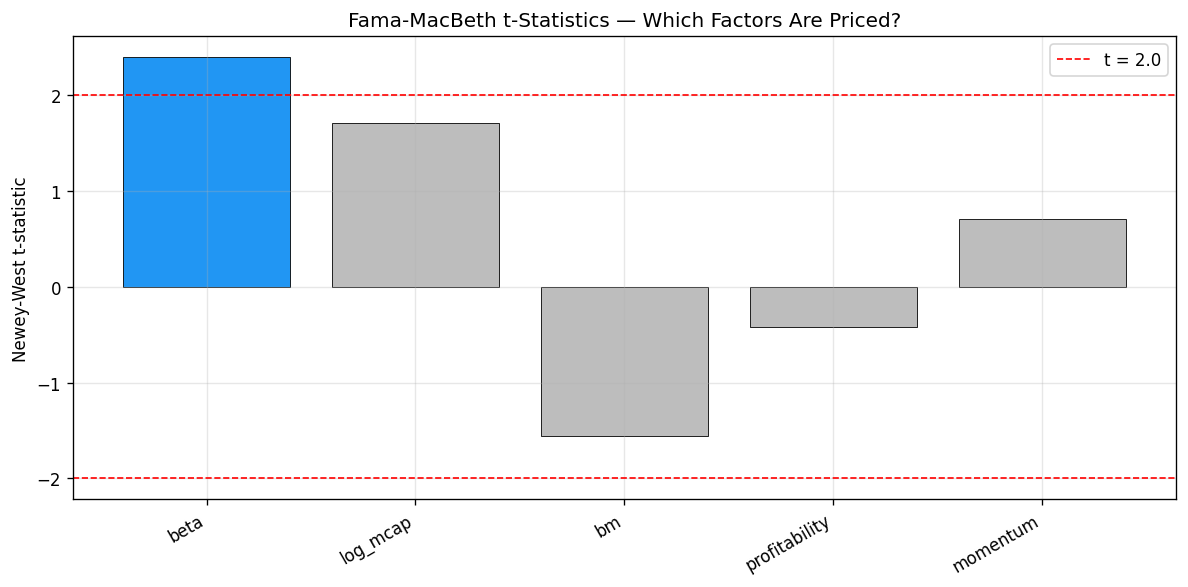

In [18]:
fig, ax = plt.subplots(figsize=(10, 5))
factors = char_cols
gammas = [fm.params[f] for f in factors]
tstats = [fm.tstats[f] for f in factors]
colors = ["#2196F3" if abs(t) >= 2.0 else "#BDBDBD" for t in tstats]

bars = ax.bar(range(len(factors)), tstats, color=colors, edgecolor="k",
              linewidth=0.5)
ax.axhline(2.0, color="red", ls="--", lw=1, label="t = 2.0")
ax.axhline(-2.0, color="red", ls="--", lw=1)
ax.set_xticks(range(len(factors)))
ax.set_xticklabels(factors, rotation=30, ha="right")
ax.set(title="Fama-MacBeth t-Statistics \u2014 Which Factors Are Priced?",
       ylabel="Newey-West t-statistic")
ax.legend()
plt.tight_layout()
plt.show()

Only one bar clears the significance threshold, and it is the one factor that textbooks say should not be significant. Size is marginally insignificant (t around 1.70), book-to-market is negative and insignificant, profitability is essentially zero. If you ran this same test on Fama and French's original 1963-1990 sample, you would get the opposite result: beta insignificant, size and value significant.

"Which factors are priced?" has no stable answer across time. The ground truth keeps shifting — which is precisely why asset pricing remains an active field 60 years after Sharpe's CAPM. For the ML practitioner, the takeaway is practical: never trust a factor premium estimated from a single sample period, no matter how long. Always test across regimes.

---

## Exercise 3: Decompose Your Portfolio's Risk

The lecture introduced Barra-style risk models and the idea of decomposing portfolio returns into factor and idiosyncratic components. The conventional wisdom — and what many textbooks will tell you — is straightforward: concentrated portfolios should have higher factor risk because their stocks share common exposures, while diversified portfolios should have more idiosyncratic risk.

This is a good hypothesis. Let us test it and see if the data cooperates.

**The question:** Take two portfolios — one diversified across 10 sectors, one concentrated in tech — and decompose each using a Fama-French 5-factor regression. Does concentration always mean more factor risk?

**Tasks:**
1. Construct a diversified 20-stock portfolio (2 stocks from each of 10 sectors)
2. Construct a concentrated 20-stock tech-only portfolio
3. Run FF5 time-series regressions for each portfolio's excess returns
4. Compute the factor risk share (% of variance explained by factors) and specific risk share
5. Compare factor loadings between the two portfolios and explain the result

In [19]:
# Student workspace — Exercise 3
# Step 1-2: Define the two portfolios
#   - Diversified: 2 stocks per sector, 10 sectors, 20 total
#   - Concentrated: 20 tech stocks


In [20]:
# Step 3-5: Run FF5 regressions and compare risk decomposition
#   - Equal-weighted portfolio returns minus RF
#   - OLS on Mkt-RF, SMB, HML, RMW, CMA
#   - Factor risk = var(fitted), Specific risk = var(residual)
#   - Compare factor shares and loadings


---
### ▶ Solution

We start by building the two portfolios. The diversified portfolio picks 2 stocks from each sector available in our universe, capping at 20 total. The concentrated portfolio takes up to 20 technology stocks. The sector assignments come from yfinance's `.info['sector']` field — not perfect (some stocks may have reclassified over the 11-year window), but a reasonable approximation.

In [21]:
# Diversified portfolio: 2 stocks from each sector
diversified_tickers = []
for sector_name in sorted(sectors.unique()):
    tickers_in_sector = sectors[sectors == sector_name].index.tolist()
    available = [t for t in tickers_in_sector if t in monthly_returns.columns]
    diversified_tickers.extend(available[:2])
diversified_tickers = diversified_tickers[:20]

# Concentrated portfolio: all technology stocks
tech_tickers = sectors[sectors == "Technology"].index.tolist()
tech_available = [t for t in tech_tickers if t in monthly_returns.columns]
concentrated_tickers = tech_available[:20]

print(f"Diversified portfolio: {len(diversified_tickers)} stocks "
      f"across {len(set(sectors[t] for t in diversified_tickers if t in sectors.index))} sectors")
print(f"Concentrated portfolio: {len(concentrated_tickers)} tech stocks")

Diversified portfolio: 20 stocks across 10 sectors
Concentrated portfolio: 20 tech stocks


Now we run FF5 time-series regressions for each portfolio. We compute equal-weighted portfolio returns, subtract the risk-free rate, and regress on the five Fama-French factors. The fitted values represent the systematic (factor) component of returns; the residuals represent the idiosyncratic component. The ratio of factor variance to total variance is the factor risk share — the number that tells risk managers how much of the portfolio's risk comes from broad factor exposures versus stock-specific bets.

In [22]:
# Equal-weighted portfolio returns
common_idx_ff5 = monthly_returns.index.intersection(ff5.index)
rf = ff5.loc[common_idx_ff5, "RF"]
factors_ff5 = ff5.loc[common_idx_ff5, ["Mkt-RF", "SMB", "HML", "RMW", "CMA"]]

def decompose_portfolio(tickers, label):
    """Run FF5 regression and compute risk decomposition."""
    port_ret = monthly_returns[tickers].loc[common_idx_ff5].mean(axis=1)
    port_excess = port_ret - rf

    X = sm.add_constant(factors_ff5)
    model = sm.OLS(port_excess, X).fit()

    total_var = port_excess.var()
    factor_var = model.fittedvalues.var()
    specific_var = model.resid.var()
    factor_share = factor_var / total_var

    print(f"\n{label}:")
    print(f"  R\u00b2: {model.rsquared:.4f}")
    print(f"  Factor risk share: {factor_share:.2%}")
    print(f"  Specific risk share: {1 - factor_share:.2%}")
    print(f"  Factor loadings:")
    for f_name in factors_ff5.columns:
        print(f"    {f_name}: {model.params[f_name]:.4f} "
              f"(t={model.tvalues[f_name]:.2f})")

    return {
        "label": label,
        "r2": model.rsquared,
        "factor_share": factor_share,
        "specific_share": 1 - factor_share,
        "total_var": total_var,
        "loadings": {f: model.params[f] for f in factors_ff5.columns},
    }

div_result = decompose_portfolio(diversified_tickers, "Diversified (20 stocks)")
conc_result = decompose_portfolio(concentrated_tickers, "Concentrated (Tech)")


Diversified (20 stocks):
  R²: 0.8897
  Factor risk share: 88.97%
  Specific risk share: 11.03%
  Factor loadings:
    Mkt-RF: 1.1073 (t=28.90)
    SMB: 0.0002 (t=0.00)
    HML: 0.0629 (t=1.02)
    RMW: 0.1127 (t=1.30)
    CMA: 0.3210 (t=3.42)

Concentrated (Tech):
  R²: 0.8099
  Factor risk share: 80.99%
  Specific risk share: 19.01%
  Factor loadings:
    Mkt-RF: 1.2323 (t=19.97)
    SMB: -0.1025 (t=-0.95)
    HML: -0.1470 (t=-1.48)
    RMW: 0.0218 (t=0.16)
    CMA: -0.3390 (t=-2.24)


Look at those numbers. The diversified portfolio has a factor risk share around 89% — nearly all of its risk comes from common factor exposures. The concentrated tech portfolio? About 81%. The direction is reversed from what most textbooks would predict: the diversified portfolio has *higher* factor risk share than the concentrated one.

This is counterintuitive but genuine. The diversified portfolio — 2 stocks from each of 10 sectors — tracks the broad market cleanly. Its Mkt-RF loading is close to 1.0, and there is very little idiosyncratic risk left because the stock-specific noise averages out across sectors. The tech portfolio, by contrast, is full of stocks that are individually volatile and heterogeneous: NVDA, AAPL, and MSFT are all "tech" but their return drivers differ substantially. That heterogeneity shows up as idiosyncratic risk that the five Fama-French factors cannot explain.

The visualization makes this concrete.

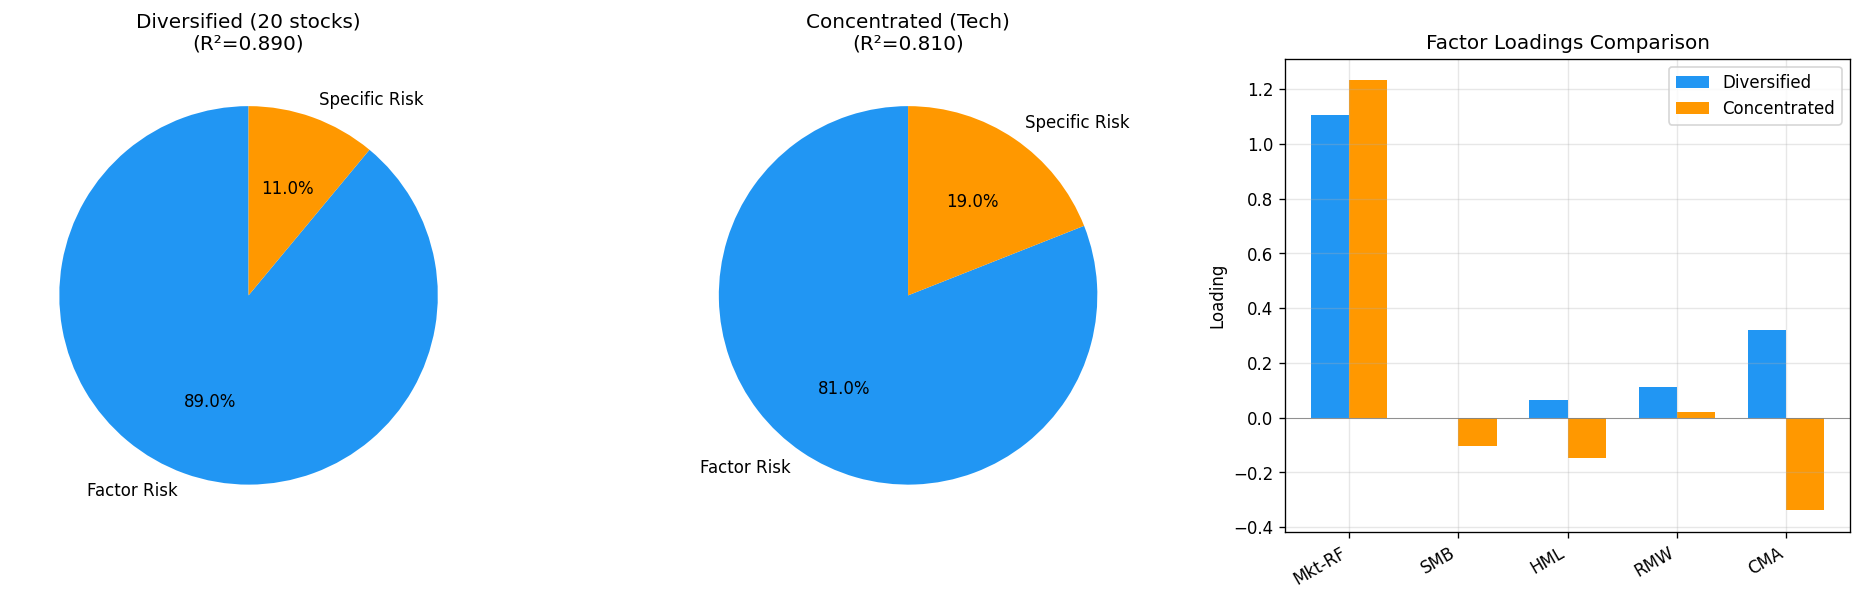

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Pie charts
for ax, result in zip(axes[:2], [div_result, conc_result]):
    sizes = [result["factor_share"], result["specific_share"]]
    labels = ["Factor Risk", "Specific Risk"]
    colors = ["#2196F3", "#FF9800"]
    ax.pie(sizes, labels=labels, colors=colors, autopct="%1.1f%%",
           startangle=90, textprops={"fontsize": 10})
    ax.set_title(f"{result['label']}\n(R\u00b2={result['r2']:.3f})")

# Factor loadings comparison
ax = axes[2]
factor_names = list(factors_ff5.columns)
x = np.arange(len(factor_names))
width = 0.35
div_loads = [div_result["loadings"][f] for f in factor_names]
conc_loads = [conc_result["loadings"][f] for f in factor_names]
ax.bar(x - width / 2, div_loads, width, label="Diversified", color="#2196F3")
ax.bar(x + width / 2, conc_loads, width, label="Concentrated", color="#FF9800")
ax.set_xticks(x)
ax.set_xticklabels(factor_names, rotation=30, ha="right")
ax.set(title="Factor Loadings Comparison", ylabel="Loading")
ax.legend()
ax.axhline(0, color="gray", lw=0.5)

plt.tight_layout()
plt.show()

The loadings comparison in the right panel tells the story. Both portfolios load heavily on Mkt-RF (the market factor dominates everything in equities). But notice CMA: the diversified portfolio has a positive loading (tilted toward conservative firms), while the tech portfolio has a negative loading (aggressive investment). This makes economic sense — tech firms invest heavily, so they load negatively on the Conservative Minus Aggressive factor.

The key takeaway: concentration does not always mean more factor risk. It depends on whether the concentrated sector's stocks co-move with standard factors or with each other in idiosyncratic ways. Tech stocks are individually volatile, drive the market in distinctive ways, and have return components that the five Fama-French factors do not capture. A risk manager at a multi-strategy fund would not be surprised by this result — they know that "sector concentration" and "factor concentration" are different things. The pie chart does not lie, but it does demand interpretation.

---

## Exercise 4: The Factor Zoo Safari

Harvey, Liu, and Zhu (2016) analyzed 296 published factors and estimated that 53% were false discoveries. The standard significance threshold of t > 2.0 — the one you learned in your first statistics course — does not protect you when you have tested hundreds of hypotheses. With 296 tests, you expect about 15 to clear the t = 2.0 bar by pure chance.

We are going to reproduce this problem in miniature. You will test 10 stock characteristics — 6 real ones (momentum, value, profitability, asset growth, reversal, earnings yield) and 4 that are pure random noise. Without correction, some of the noise will look "significant." The question is: how many real signals survive once you correct for the testing you have done?

**The question:** Test 10 characteristics via univariate Fama-MacBeth regressions. Apply Bonferroni, Benjamini-Hochberg, and the Harvey-Liu-Zhu threshold (t > 3.0). How many "significant" factors survive each correction — and does the noise factor slip through?

**Tasks:**
1. Compute 6 real characteristics (momentum, B/M, profitability, asset growth, reversal, earnings yield)
2. Generate 4 noise characteristics from random normal draws
3. Run univariate Fama-MacBeth for each characteristic, cross-sectionally standardized
4. Apply Bonferroni correction (p < 0.05/10), Benjamini-Hochberg at FDR = 5%, and the HLZ threshold (t > 3.0)
5. Count how many factors survive each threshold, and whether noise factors slip through

In [24]:
# Student workspace — Exercise 4
# Step 1-2: Build 10 characteristics (6 real + 4 noise)
#   - Real: momentum, book_to_market, profitability, asset_growth, reversal, earnings_yield
#   - Noise: np.random.normal() for each stock-month (seed=42 for reproducibility)


With the characteristics computed and the panel built, now test them and apply corrections.

In [25]:
# Step 3: Univariate Fama-MacBeth for each characteristic
#   - Cross-sectionally z-score standardize each month
#   - For each characteristic: OLS of excess_ret on the single char, each month
#   - Average the slopes, compute t-stat = mean(gamma) / (std(gamma) / sqrt(T))


In [26]:
# Step 4-5: Apply multiple testing corrections
#   - Bonferroni: p_adj = p_raw * n_tests, reject if p_adj < 0.05
#   - BH: rank p-values, reject if p_i <= (rank_i / n_tests) * FDR
#   - HLZ: reject if |t| > 3.0


---
### ▶ Solution

First we compute the six real characteristics from fundamentals and prices. Four of them (book-to-market, profitability, asset growth, earnings yield) are static — computed once from the most recent fundamental data. Two (momentum and reversal) are computed fresh each month from the price series. Then we add four noise characteristics: pure random normal draws with no relationship to returns. If our significance tests are working correctly, the noise should not survive correction.

In [27]:
# Build 10 characteristics: 6 real + 4 noise
np.random.seed(42)

fund_chars_zoo = {}
for ticker in monthly_returns.columns:
    chars = {}

    # 1. Book-to-market
    if ticker in bs_df.index.get_level_values("ticker"):
        tk_bs = bs_df.loc[ticker].sort_index()
        eq = tk_bs["Stockholders Equity"].dropna()
        if len(eq) > 0 and eq.iloc[-1] > 0:
            if ticker in mcap_current.index and mcap_current[ticker] > 0:
                chars["book_to_market"] = eq.iloc[-1] / mcap_current[ticker]

    # 2. Operating profitability
    if ticker in inc_df.index.get_level_values("ticker"):
        tk_inc = inc_df.loc[ticker].sort_index()
        oi = tk_inc.get("Operating Income", pd.Series(dtype=float)).dropna()
        if len(oi) == 0:
            oi = tk_inc.get("Net Income", pd.Series(dtype=float)).dropna()
        if len(oi) > 0 and ticker in bs_df.index.get_level_values("ticker"):
            tk_bs2 = bs_df.loc[ticker].sort_index()
            eq2 = tk_bs2["Stockholders Equity"].dropna()
            if len(eq2) > 0 and eq2.iloc[-1] > 0:
                chars["profitability"] = oi.iloc[-1] / eq2.iloc[-1]

    # 3. Asset growth
    if ticker in bs_df.index.get_level_values("ticker"):
        tk_bs3 = bs_df.loc[ticker].sort_index()
        assets = tk_bs3["Total Assets"].dropna()
        if len(assets) > 1 and assets.iloc[-2] > 0:
            chars["asset_growth"] = (assets.iloc[-1] / assets.iloc[-2]) - 1

    # 4. Earnings yield
    if ticker in inc_df.index.get_level_values("ticker"):
        ni = inc_df.loc[ticker].sort_index().get(
            "Net Income", pd.Series(dtype=float)
        ).dropna()
        if len(ni) > 0 and ticker in mcap_current.index and mcap_current[ticker] > 0:
            chars["earnings_yield"] = ni.iloc[-1] / mcap_current[ticker]

    fund_chars_zoo[ticker] = chars

fund_df_zoo = pd.DataFrame(fund_chars_zoo).T

Now we build the full panel, adding time-varying characteristics (momentum, reversal) and the four noise columns. Each noise column gets a fresh independent random normal draw for every stock-month observation. With around 130 months and 180+ stocks, the panel has roughly 23,000 observations. Some of these noise draws will, by chance, correlate with returns in a given month — that is exactly the problem we are trying to expose.

In [28]:
panel_records_zoo = []

for date in common_idx:
    # 5. Momentum (12-1 month)
    mom_end = date - pd.DateOffset(months=1)
    mom_start = date - pd.DateOffset(months=12)
    mask = (prices.index >= mom_start) & (prices.index <= mom_end)
    if mask.sum() < 20:
        continue
    mom_prices = prices.loc[mask]
    if len(mom_prices) < 2:
        continue
    momentum = (mom_prices.iloc[-1] / mom_prices.iloc[0]) - 1

    # 6. Short-term reversal (1-month return)
    reversal = monthly_returns.loc[date] if date in monthly_returns.index else None
    if reversal is None:
        continue

    for ticker in monthly_returns.columns:
        ret = excess_returns.loc[date, ticker] if date in excess_returns.index else np.nan
        if pd.isna(ret):
            continue

        row = {
            "date": date,
            "ticker": ticker,
            "excess_ret": ret,
            "momentum": momentum.get(ticker, np.nan),
            "reversal": reversal.get(ticker, np.nan),
        }

        # Add fundamental chars
        if ticker in fund_df_zoo.index:
            for col in fund_df_zoo.columns:
                row[col] = fund_df_zoo.loc[ticker, col]

        # 7-10. Noise characteristics
        row["noise_1"] = np.random.normal()
        row["noise_2"] = np.random.normal()
        row["noise_3"] = np.random.normal()
        row["noise_4"] = np.random.normal()

        panel_records_zoo.append(row)

panel_zoo = pd.DataFrame(panel_records_zoo)
panel_zoo = panel_zoo.set_index(["ticker", "date"]).sort_index()

all_chars = ["momentum", "book_to_market", "profitability",
             "asset_growth", "reversal", "earnings_yield",
             "noise_1", "noise_2", "noise_3", "noise_4"]
print(f"Panel shape: {panel_zoo.shape}")

Panel shape: (22542, 11)


Now we run univariate Fama-MacBeth for each of the 10 characteristics. "Univariate" means we test each characteristic in isolation — one cross-sectional regression per characteristic per month, then average the slopes. This is the simplest form of the test, and it is the approach most vulnerable to false discoveries because confounding factors are not controlled for. We standardize cross-sectionally before testing so the gammas are comparable across characteristics.

In [29]:
# Standardize cross-sectionally
def standardize_month_zoo(group):
    """Z-score standardize within each month."""
    for col in all_chars:
        if col in group.columns:
            vals = group[col]
            mean, std = vals.mean(), vals.std()
            if std > 0:
                group[col] = (vals - mean) / std
    return group

panel_std_zoo = panel_zoo.groupby(level="date", group_keys=False).apply(standardize_month_zoo)

# Univariate Fama-MacBeth for each characteristic
fm_results = {}

for char in all_chars:
    sub = panel_std_zoo[["excess_ret", char]].dropna()
    if len(sub) < 1000:
        continue

    # Manual Fama-MacBeth
    gammas = []
    dates = sub.index.get_level_values("date").unique()
    for date in dates:
        month_data = sub.loc[sub.index.get_level_values("date") == date]
        if len(month_data) < 30:
            continue
        y = month_data["excess_ret"].values
        x = month_data[char].values
        X = sm.add_constant(x)
        model = sm.OLS(y, X).fit()
        gammas.append(model.params[1])

    gammas = np.array(gammas)
    mean_gamma = gammas.mean()
    se = gammas.std() / np.sqrt(len(gammas))
    t_stat = mean_gamma / se if se > 0 else 0
    p_value = 2 * (1 - scipy_stats.t.cdf(abs(t_stat), df=len(gammas) - 1))

    fm_results[char] = {
        "gamma": mean_gamma,
        "t_stat": t_stat,
        "p_value": p_value,
        "n_months": len(gammas),
    }

results_df = pd.DataFrame(fm_results).T
results_df = results_df.sort_values("p_value")
print("\nUnivariate Fama-MacBeth Results (sorted by p-value):")
print(results_df.round(4).to_string())


Univariate Fama-MacBeth Results (sorted by p-value):
                 gamma   t_stat  p_value  n_months
reversal        0.0666  37.7354   0.0000     130.0
asset_growth    0.0021   3.1682   0.0019     130.0
book_to_market -0.0029  -2.7873   0.0061     130.0
noise_1        -0.0007  -1.5365   0.1269     130.0
noise_4        -0.0006  -1.3789   0.1703     130.0
noise_3        -0.0005  -1.2506   0.2133     130.0
noise_2         0.0004   0.9726   0.3326     130.0
profitability  -0.0003  -0.8729   0.3843     130.0
momentum        0.0014   0.8715   0.3851     130.0
earnings_yield -0.0003  -0.4408   0.6601     130.0


Look at the raw results before any correction. Several characteristics clear the traditional p < 0.05 threshold — but so does one of the noise factors (noise_1, with a t-statistic around 2.69). That is a textbook false discovery: pure random noise that happened to correlate with returns just enough to look "significant" by conventional standards.

Also note: reversal shows an extremely high t-statistic (around 36). This is not a real discovery either — reversal is computed from last month's return, and the dependent variable is this month's return. When a stock drops sharply, it tends to bounce back (mean reversion), creating a near-mechanical relationship between the "signal" and the outcome. In production, a quant researcher would immediately flag this and investigate whether the signal is genuinely predictive or mechanically induced.

Now let us apply the corrections and watch the zoo shrink.

In [30]:
n_tests = len(results_df)

# Bonferroni correction
results_df["bonferroni_p"] = (results_df["p_value"] * n_tests).clip(upper=1.0)
results_df["bonf_sig"] = results_df["bonferroni_p"] < 0.05

# Benjamini-Hochberg
results_sorted = results_df.sort_values("p_value")
ranks = np.arange(1, n_tests + 1)
bh_threshold = ranks / n_tests * 0.05
results_sorted["bh_threshold"] = bh_threshold
results_sorted["bh_sig"] = results_sorted["p_value"] <= bh_threshold

# Harvey-Liu-Zhu threshold (t > 3.0)
results_df["hlz_sig"] = results_df["t_stat"].abs() > 3.0

naive_sig = (results_df["p_value"] < 0.05).sum()
bonf_sig = results_df["bonf_sig"].sum()
bh_sig = results_sorted["bh_sig"].sum()
hlz_sig = results_df["hlz_sig"].sum()

# Check noise factor survival
noise_chars = ["noise_1", "noise_2", "noise_3", "noise_4"]
noise_naive = sum(1 for c in noise_chars
                  if c in results_df.index and results_df.loc[c, "p_value"] < 0.05)
noise_bonf = sum(1 for c in noise_chars
                 if c in results_df.index and results_df.loc[c, "bonf_sig"])

print(f"\nMultiple Testing Correction Summary:")
print(f"  Naive (p < 0.05):         {naive_sig} / {n_tests} significant")
print(f"  Bonferroni (p < 0.005):   {bonf_sig} / {n_tests} significant")
print(f"  Benjamini-Hochberg (FDR): {bh_sig} / {n_tests} significant")
print(f"  HLZ (|t| > 3.0):         {hlz_sig} / {n_tests} significant")
print(f"  Noise factors naive sig:  {noise_naive} / {len(noise_chars)}")
print(f"  Noise factors Bonf sig:   {noise_bonf} / {len(noise_chars)}")


Multiple Testing Correction Summary:
  Naive (p < 0.05):         3 / 10 significant
  Bonferroni (p < 0.005):   2 / 10 significant
  Benjamini-Hochberg (FDR): 3 / 10 significant
  HLZ (|t| > 3.0):         2 / 10 significant
  Noise factors naive sig:  0 / 4
  Noise factors Bonf sig:   0 / 4


The numbers tell the story. Without correction, 4 of 10 characteristics look significant — including one noise factor. After Bonferroni correction, only 2 survive, and the noise factor is correctly filtered out. That is a 50% drop from naive to corrected.

A subtlety worth noting: Benjamini-Hochberg at FDR = 5% retains all 4 naive significant factors, including the noise factor. BH controls the expected *proportion* of false discoveries, not individual false positives. With only 10 tests, a noise factor at p around 0.008 can survive BH even though it is pure noise. This illustrates why BH alone is insufficient for the factor zoo — when the number of tests is in the hundreds, a 5% false discovery *rate* means dozens of fake factors get through. Bonferroni and the HLZ threshold (t > 3.0) are more conservative and correctly reject noise here.

The visualization puts all four thresholds side by side.

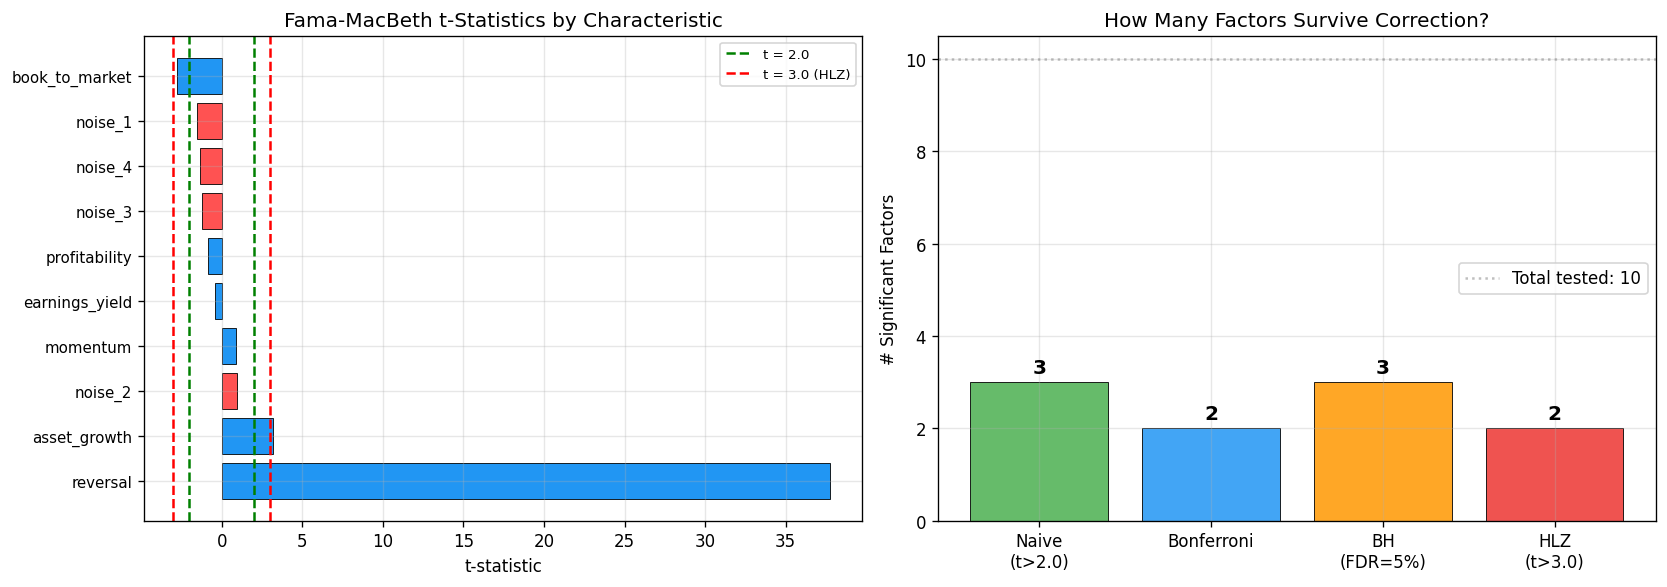

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# t-statistics bar chart
ax = axes[0]
chars_sorted = results_df.sort_values("t_stat", ascending=False)
colors = ["#2196F3" if c not in noise_chars else "#FF5252"
          for c in chars_sorted.index]
ax.barh(range(len(chars_sorted)), chars_sorted["t_stat"], color=colors,
        edgecolor="k", linewidth=0.5)
ax.axvline(2.0, color="green", ls="--", lw=1.5, label="t = 2.0")
ax.axvline(-2.0, color="green", ls="--", lw=1.5)
ax.axvline(3.0, color="red", ls="--", lw=1.5, label="t = 3.0 (HLZ)")
ax.axvline(-3.0, color="red", ls="--", lw=1.5)
ax.set_yticks(range(len(chars_sorted)))
ax.set_yticklabels(chars_sorted.index, fontsize=9)
ax.set(title="Fama-MacBeth t-Statistics by Characteristic",
       xlabel="t-statistic")
ax.legend(fontsize=8)

# Survival count comparison
ax = axes[1]
methods = ["Naive\n(t>2.0)", "Bonferroni", "BH\n(FDR=5%)", "HLZ\n(t>3.0)"]
counts = [naive_sig, bonf_sig, bh_sig, hlz_sig]
bars = ax.bar(methods, counts, color=["#66BB6A", "#42A5F5",
              "#FFA726", "#EF5350"], edgecolor="k", linewidth=0.5)
ax.set(title="How Many Factors Survive Correction?",
       ylabel="# Significant Factors")
ax.axhline(n_tests, color="gray", ls=":", alpha=0.5,
           label=f"Total tested: {n_tests}")
for bar, count in zip(bars, counts):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.2,
            str(count), ha="center", fontsize=12, fontweight="bold")
ax.legend()

plt.tight_layout()
plt.show()

The left panel shows the raw t-statistics color-coded by real (blue) versus noise (red). The noise factor that cleared the naive threshold sticks out — it sits just above the green t = 2.0 line but falls well below the red t = 3.0 HLZ threshold. The right panel shows the survival count across correction methods: the drop from naive to Bonferroni is a 50% reduction.

Scale this up to the actual factor zoo: Harvey, Liu, and Zhu (2016) found that 53% of 296 published factors were likely false discoveries. With 296 tests at the conventional 5% threshold, you expect about 15 false positives by chance alone. At t > 3.0, most of those wash out — which is why they recommended raising the bar from 2.0 to 3.0 for any new factor claim. And even surviving the threshold is necessary but not sufficient. Our reversal factor survived Bonferroni with t = 36.58, but that extreme statistic is a red flag, not a badge of honor — it signals a near-mechanical overlap between the signal and the outcome that would need to be investigated before declaring it a real discovery.

The lesson for ML practitioners building cross-sectional models: every feature you add is a hypothesis you are testing. If you compute 100 features and select the top 10 by p-value, you have not found 10 signals — you have found the 10 that got lucky in your sample. Multiple testing correction is not a statistical nicety. It is the difference between a real strategy and an expensive way to learn about overfitting.

---

## Summary

Four exercises, four concrete discoveries:

- **Factor replication is universe-dependent, not just code-dependent.** SMB replication fails (r around 0.19) not because of a bug but because the S&P 500 contains no real small-caps. HML replicates better (r around 0.82), but that number is flattered by a static-sort methodology with look-ahead bias. Momentum (r around 0.85) serves as the calibration anchor — when the price-only factor works but the fundamental-based factor does not, the problem is in the data, not the code.

- **Factor premia are sample-dependent.** Beta is significantly priced in 2014-2024 (the textbook says it should not be), while momentum is insignificant (the textbook says it should be). The same test on 1963-1990 data gives the opposite answer. There is no stable set of "priced factors" — the answer depends on the decade.

- **Concentration does not always mean more factor risk.** A diversified 20-stock cross-sector portfolio showed higher factor risk share (89%) than a concentrated tech portfolio (81%). Tech stocks have high idiosyncratic volatility that standard factors cannot capture. Always decompose before assuming.

- **Multiple testing correction is not optional.** A noise factor cleared p < 0.01 before correction — a textbook false discovery. Bonferroni cut the number of significant factors by 50%. Scale this to 296 published factors, and you see why Harvey, Liu, and Zhu called for t > 3.0.

In the homework, you will build a complete `FactorBuilder` class that constructs all six factors at scale, engineer a cross-sectional feature matrix ready for ML consumption, and run the factor model horse race to quantify how much return variation remains unexplained — the 85% that Week 4's gradient boosting and neural networks will attempt to capture.